In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense

In [2]:
seed = 20
plt.style.use('seaborn')

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load Datasets

In [4]:
df_people = pd.read_csv("./train.csv")

In [5]:
df_people.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),...,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,...,0,8,0,0,68.85,72.53,0.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,...,9,3,0,0,94.81,101.13,3.0,achiev_50%-100%,achiev_50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,...,0,6,0,0,72.82,71.30,0.0,achiev_100%-150%,achiev_< 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,...,0,3,0,0,86.89,90.09,2.0,achiev_50%-100%,achiev_50%-100%,not_reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,...,11,2,1,1,95.17,100.72,2.0,achiev_< 50%,achiev_> 1.5,not_reached


In [6]:
columns_to_keep = ['job_level', 'job_duration_in_current_job_level', 'person_level', 
                   'job_duration_in_current_person_level', 'job_duration_in_current_branch', 'Employee_type', 
                   'Employee_status', 'gender', 'age', 'marital_status_maried(Y/N)', 'number_of_dependences', 
                   'number_of_dependences (male)', 'number_of_dependences (female)', 'GPA', 
                   'job_duration_as_permanent_worker', 'job_duration_from_training', 'branch_rotation', 
                   'job_rotation', 'assign_of_otherposition', 'annual leave', 'sick_leaves', 'Avg_achievement_%', 
                   'Last_achievement_%', 'Achievement_above_100%_during3quartal', 'achievement_target_1', 
                   'achievement_target_2', 'achievement_target_3', 'Best Performance']

df_people = df_people[columns_to_keep]

In [7]:
# under-sampling
# df_people_0 = df_people[df_people['Best Performance'] == 0][:4000]
# df_people_1 = df_people[df_people['Best Performance'] == 1]

# df_people = pd.concat([df_people_0, df_people_1])

# sns.countplot(x='Best Performance', data=df_people)
# plt.show()

## Preprocess Data

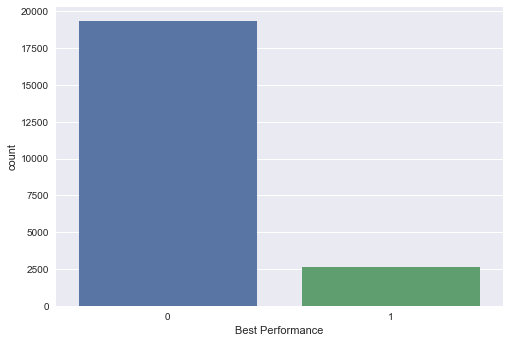

In [8]:
sns.countplot(x='Best Performance', data=df_people)
plt.show()

In [9]:
# convert year birth into age
now = datetime.datetime.now()
current_year = now.year
df_people['age'] = current_year - df_people['age']

# change Y/N into 1/0
df_people['marital_status_maried(Y/N)'] = df_people['marital_status_maried(Y/N)'].map(dict(Y=1, N=0))

# change text into score
df_target = df_people['achievement_target_1']

df_target[df_target == 'Tidak diberikan target'] = 0
df_target[df_target == 'achiev_< 50%'] = 1; df_target[df_target == 'Pencapaian < 50%'] = 1
df_target[df_target == 'achiev_> 1.5'] = 1.5; df_target[df_target == 'Pencapaian > 1.5'] = 1.5
df_target[df_target == 'achiev_50%-100%'] = 2; df_target[df_target == 'Pencapaian 50%-100%'] = 2
df_target[df_target == 'achiev_100%-150%'] = 3; df_target[df_target == 'Pencapaian 100%-150%'] = 3

df_target = df_people['achievement_target_2']

df_target[df_target == 'Tidak diberikan target'] = 0
df_target[df_target == 'achiev_< 50%'] = 1; df_target[df_target == 'Pencapaian < 50%'] = 1
df_target[df_target == 'achiev_> 1.5'] = 1.5; df_target[df_target == 'Pencapaian > 1.5'] = 1.5
df_target[df_target == 'achiev_50%-100%'] = 2; df_target[df_target == 'Pencapaian 50%-100%'] = 2
df_target[df_target == 'achiev_100%-150%'] = 3; df_target[df_target == 'Pencapaian 100%-150%'] = 3

df_target = df_people['achievement_target_3']

df_target[df_target == 'not_reached'] = 0
df_target[df_target == 'not reached'] = 0
df_target[df_target == 'reached'] = 1

Total rows: 22005
Total features: 28


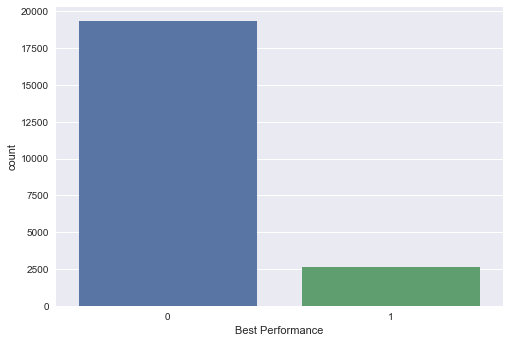

In [10]:
# fill missing values
df_people = df_people.fillna(df_people.mean())

print('Total rows:', df_people.shape[0])
print('Total features:', df_people.shape[1])

sns.countplot(x='Best Performance', data=df_people)
plt.show()

In [11]:
# process categorical data (one-hot-encoding)
cat_vars = ['Employee_type', 'Employee_status', 'gender']
for var in cat_vars:
    data_dummies = pd.get_dummies(df_people[var], prefix=var)
    df_people = pd.concat([df_people, data_dummies], axis=1)

In [12]:
# remove categorical data
data_vars = df_people.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars] # filter process

df_people = df_people[to_keep]
df_people.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),...,achievement_target_2,achievement_target_3,Best Performance,Employee_type_RM_type_A,Employee_type_RM_type_B,Employee_type_RM_type_C,Employee_status_Contract,Employee_status_Permanent,gender_Female,gender_Male
0,JG05,8.00,PG06,8.00,0.50,56,1,3,1,2,...,1.0,1.0,0,1,0,0,0,1,1,0
1,JG04,5.17,PG04,2.00,1.25,41,1,3,2,1,...,2.0,1.0,0,1,0,0,0,1,0,1
2,JG04,1.83,PG03,1.83,1.50,40,1,1,0,1,...,1.0,0.0,0,1,0,0,0,1,0,1
3,JG04,7.92,PG04,4.00,0.17,36,1,0,0,0,...,2.0,0.0,0,1,0,0,0,1,0,1
4,JG04,1.83,PG03,1.83,2.08,36,1,1,0,1,...,1.5,0.0,1,1,0,0,0,1,0,1


In [13]:
# process categorical data (label-encoding)
le = LabelEncoder()

df_people['jl_label'] = le.fit_transform(df_people.loc[:, 'job_level'])
df_people['pl_label'] = le.fit_transform(df_people.loc[:, 'person_level'])

In [14]:
# remove categorical data
del df_people['job_level']
del df_people['person_level']

df_people.head()

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),GPA,job_duration_as_permanent_worker,...,Best Performance,Employee_type_RM_type_A,Employee_type_RM_type_B,Employee_type_RM_type_C,Employee_status_Contract,Employee_status_Permanent,gender_Female,gender_Male,jl_label,pl_label
0,8.00,8.00,0.50,56,1,3,1,2,2.320000,30.0,...,0,1,0,0,0,1,1,0,2,5
1,5.17,2.00,1.25,41,1,3,2,1,3.250000,15.0,...,0,1,0,0,0,1,0,1,1,3
2,1.83,1.83,1.50,40,1,1,0,1,3.230000,15.0,...,0,1,0,0,0,1,0,1,1,2
3,7.92,4.00,0.17,36,1,0,0,0,0.000000,8.0,...,0,1,0,0,0,1,0,1,1,3
4,1.83,1.83,2.08,36,1,1,0,1,2.994603,7.0,...,1,1,0,0,0,1,0,1,1,2


In [15]:
data_vars = df_people.columns.values.tolist()
y = ['Best Performance']
X = [i for i in data_vars if i not in y]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_people[X], df_people[y], test_size=0.3, random_state=seed)

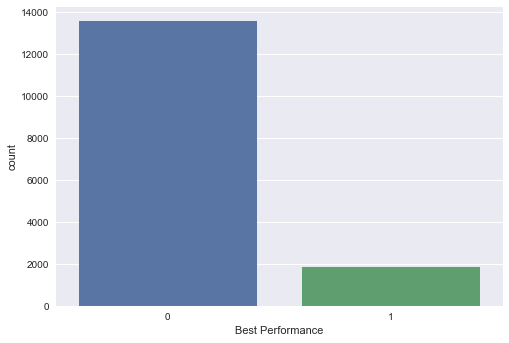

In [17]:
sns.countplot(x='Best Performance', data=y_train)
plt.show()

In [18]:
# under-sampling
# Xy_train = pd.concat([X_train, y_train], axis=1)
# Xy_train_0 = Xy_train[Xy_train['Best Performance'] == 0][:2000]
# Xy_train_1 = Xy_train[Xy_train['Best Performance'] == 1]

# Xy_train = pd.concat([Xy_train_0, Xy_train_1])

# X_train = Xy_train[Xy_train.columns[:-1]]
# y_train = Xy_train[['Best Performance']]

# sns.countplot(x='Best Performance', data=y_train)
# plt.show()

## Train Model

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier

rf_clf_ = BalancedRandomForestClassifier(max_features='log2', n_estimators=10, random_state=seed)
rf_clf = EasyEnsembleClassifier(n_estimators=10, sampling_strategy='majority', random_state=seed)

rf_clf_.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

EasyEnsembleClassifier(random_state=20, sampling_strategy='majority')

## Evaluate Model

In [20]:
rf_probs = rf_clf.predict_proba(X_test)
y_pred = rf_probs[:, 1]

Random Forest ROC AUC: 0.648
Best Threshold: 0.5005437891272674



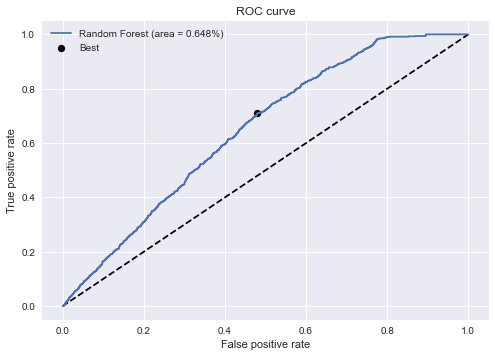

In [21]:
rf_probs = rf_clf.predict_proba(X_test)
y_pred = rf_probs[:, 1]

# set threshold
rf_auc = roc_auc_score(y_test, y_pred)

print(f'Random Forest ROC AUC: {rf_auc:.3f}')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# get the best threshold for testing
J = tpr_rf - fpr_rf
ix = np.argmax(J)
best_threshold = thresholds_rf[ix]
print(f'Best Threshold: {best_threshold}\n')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.3f}%)')
plt.scatter(fpr_rf[ix], tpr_rf[ix], marker='o', color='black', label='Best')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
y_pred[y_pred >= best_threshold] = 1
y_pred[y_pred < best_threshold] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.52      0.67      5776
           1       0.17      0.71      0.28       826

    accuracy                           0.54      6602
   macro avg       0.55      0.61      0.47      6602
weighted avg       0.83      0.54      0.62      6602



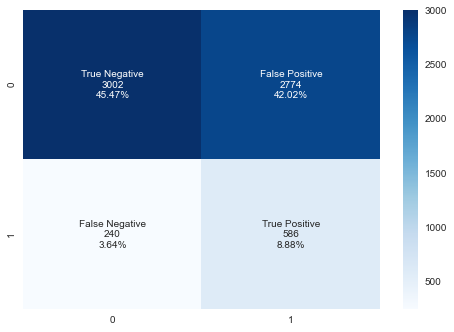

In [23]:
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

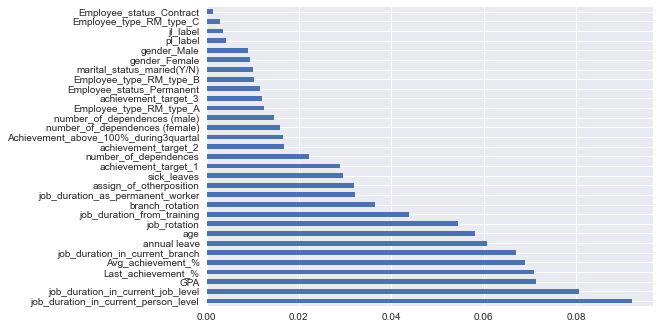

In [24]:
importance_scores = rf_clf_.feature_importances_
indices = np.argsort(importance_scores)

feature_importances = pd.Series(importance_scores, index=X)
feature_importances.nlargest(len(X)).plot(kind='barh')

## Predict!

In [25]:
df_people = pd.read_csv("./test.csv")

In [26]:
columns_to_keep = ['job_level', 'job_duration_in_current_job_level', 'person_level', 
                   'job_duration_in_current_person_level', 'job_duration_in_current_branch', 'Employee_type', 
                   'Employee_status', 'gender', 'age', 'marital_status_maried(Y/N)', 'number_of_dependences', 
                   'number_of_dependences (male)', 'number_of_dependences (female)', 'GPA', 
                   'job_duration_as_permanent_worker', 'job_duration_from_training', 'branch_rotation', 
                   'job_rotation', 'assign_of_otherposition', 'annual leave', 'sick_leaves', 'Avg_achievement_%', 
                   'Last_achievement_%', 'Achievement_above_100%_during3quartal', 'achievement_target_1', 
                   'achievement_target_2', 'achievement_target_3']

df_people = df_people[columns_to_keep]

# convert year birth into age
now = datetime.datetime.now()
current_year = now.year
df_people['age'] = current_year - df_people['age']

# change Y/N into 1/0
df_people['marital_status_maried(Y/N)'] = df_people['marital_status_maried(Y/N)'].map(dict(Y=1, N=0))

# change text into score
df_target = df_people['achievement_target_1']

df_target[df_target == 'Tidak diberikan target'] = 0
df_target[df_target == 'achiev_< 50%'] = 1; df_target[df_target == 'Pencapaian < 50%'] = 1
df_target[df_target == 'achiev_> 1.5'] = 1.5; df_target[df_target == 'Pencapaian > 1.5'] = 1.5
df_target[df_target == 'achiev_50%-100%'] = 2; df_target[df_target == 'Pencapaian 50%-100%'] = 2
df_target[df_target == 'achiev_100%-150%'] = 3; df_target[df_target == 'Pencapaian 100%-150%'] = 3

df_target = df_people['achievement_target_2']

df_target[df_target == 'Tidak diberikan target'] = 0
df_target[df_target == 'achiev_< 50%'] = 1; df_target[df_target == 'Pencapaian < 50%'] = 1
df_target[df_target == 'achiev_> 1.5'] = 1.5; df_target[df_target == 'Pencapaian > 1.5'] = 1.5
df_target[df_target == 'achiev_50%-100%'] = 2; df_target[df_target == 'Pencapaian 50%-100%'] = 2
df_target[df_target == 'achiev_100%-150%'] = 3; df_target[df_target == 'Pencapaian 100%-150%'] = 3

df_target = df_people['achievement_target_3']

df_target[df_target == 'not_reached'] = 0
df_target[df_target == 'not reached'] = 0
df_target[df_target == 'reached'] = 1

# process categorical data (one-hot-encoding)
cat_vars = ['Employee_type', 'Employee_status', 'gender']
for var in cat_vars:
    
    if var == 'Employee_status':
        # add additional feature
        df_people['Employee_status_Contract'] = 0
        
    data_dummies = pd.get_dummies(df_people[var], prefix=var)
    df_people = pd.concat([df_people, data_dummies], axis=1)
    
# remove categorical data
data_vars = df_people.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars] # filter process

df_people = df_people[to_keep]

# process categorical data (label-encoding)
le = LabelEncoder()

df_people['jl_label'] = le.fit_transform(df_people.loc[:, 'job_level'])
df_people['pl_label'] = le.fit_transform(df_people.loc[:, 'person_level'])

# remove categorical data
del df_people['job_level']
del df_people['person_level']

data_vars = df_people.columns.values.tolist()

X_test = df_people[data_vars]

In [27]:
rf_probs = rf_clf.predict_proba(X_test)
predictions = rf_probs[:, 1]

# set threshold
predictions[predictions > best_threshold] = 1
predictions[predictions < best_threshold] = 0

In [28]:
best = np.sum(predictions == 1)
not_best = np.sum(predictions == 0)

print(f'Total best performance of {best+not_best}: {best}')

Total best performance of 6000: 3373


## Create Submission

In [29]:
f = open("new_submission.csv","w+")

In [30]:
f.write("index,Best Performance\n")

for i in range(len(predictions)): 
    
    f.write(f"{i},{predictions[i]}\n") 
    
f.close()

---